KeyboardInterrupt: 

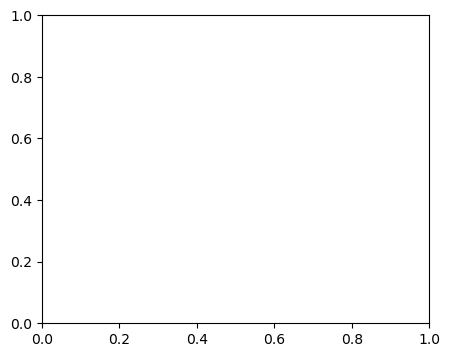

: 

In [2]:
import math
import tkinter as tk
from tkinter import ttk, messagebox
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

class NanoparticleBuilder:
    def __init__(self, root):
        self.root = root
        self.root.title("Core-Shell Nanoparticle Builder")

        self.layers = []  # Store layers as (radius, comp)
        self.colorbar = None  # Store colorbar reference

        # UI for adding layers
        self.layer_frame = ttk.Frame(root)
        self.layer_frame.pack(padx=10, pady=10, fill="x")

        ttk.Label(self.layer_frame, text="Shell Radius (nm)").grid(row=0, column=0, padx=5)
        ttk.Label(self.layer_frame, text="Composition").grid(row=0, column=1, padx=5)

        self.radius_var = tk.DoubleVar()
        self.comp_var = tk.StringVar()

        self.radius_entry = ttk.Entry(self.layer_frame, textvariable=self.radius_var, width=10)
        self.radius_entry.grid(row=1, column=0, padx=5)

        self.comp_dropdown = ttk.Combobox(self.layer_frame, textvariable=self.comp_var, width=15)
        self.comp_dropdown["values"] = [
            "Ag_evap", "Pena26Au74Ag", "Pena100Ag", "Pena34Au66Ag",
            "Au_evap", "Pena15Au85Ag", "Pena52Au48Ag"
        ]
        self.comp_dropdown.grid(row=1, column=1, padx=5)

        ttk.Button(self.layer_frame, text="+ Add Layer", command=self.add_layer).grid(row=1, column=2, padx=5)
        ttk.Button(self.layer_frame, text="- Remove Last Layer", command=self.remove_layer).grid(row=1, column=3, padx=5)

        # Display layers
        self.layer_list = tk.Listbox(root, height=8)
        self.layer_list.pack(padx=10, pady=5, fill="x")

        # Plot area
        self.figure, self.ax = plt.subplots(figsize=(5, 4))
        self.canvas = FigureCanvasTkAgg(self.figure, master=root)
        self.canvas_widget = self.canvas.get_tk_widget()
        self.canvas_widget.pack(padx=10, pady=5)

        # Plot and Save buttons
        self.button_frame = ttk.Frame(root)
        self.button_frame.pack(pady=10)

        ttk.Button(self.button_frame, text="Plot Structure", command=self.plot_structure).pack(side="left", padx=5)
        ttk.Button(self.button_frame, text="Save Shape and Parameter File", command=self.save_files).pack(side="right", padx=5)

    def add_layer(self):
        radius = self.radius_var.get()
        comp = self.comp_var.get()
        if radius <= 0 or not comp:
            messagebox.showerror("Input Error", "Radius must be positive and Composition must be selected.")
            return

        if self.layers and radius <= self.layers[-1][0]:
            messagebox.showerror("Input Error", "Radius must be larger than the previous layer.")
            return

        self.layers.append((radius, comp))
        self.layer_list.insert(tk.END, f"Radius: {radius} nm, Composition: {comp}")
        self.radius_var.set(0)
        self.comp_var.set("")

    def remove_layer(self):
        if self.layers:
            self.layers.pop()
            self.layer_list.delete(tk.END)

    def plot_structure(self):
        if not self.layers:
            messagebox.showerror("Error", "No layers to plot.")
            return

        # Clear and recreate the figure and axes to ensure a clean plot
        self.figure.clf()  # Clear the entire figure
        self.ax = self.figure.add_subplot(111)  # Recreate the axes

        # Generate a 2D slice through the center of the nanoparticle
        N = 256
        L = 0.160  # microns
        d = L / N

        x = np.linspace(-L / 2, L / 2, N)
        y = np.linspace(-L / 2, L / 2, N)
        X, Y = np.meshgrid(x, y)
        r = np.sqrt(X**2 + Y**2) * 1e3  # Convert to nm

        # Reset the composition grid and compute new values
        composition_grid = np.zeros_like(r, dtype=int)
        for i, (layer_radius, comp) in enumerate(self.layers, start=1):
            composition_grid[(r <= layer_radius) & (composition_grid == 0)] = i

        # Plot the new composition grid
        cax = self.ax.imshow(
            composition_grid,
            cmap="viridis",
            origin="lower",
            extent=[-L / 2 * 1e3, L / 2 * 1e3, -L / 2 * 1e3, L / 2 * 1e3],
        )
        self.ax.set_title("2D Cross-Section of Nanoparticle")
        self.ax.set_xlabel("X (nm)")
        self.ax.set_ylabel("Y (nm)")

        # Add a new colorbar
        self.figure.colorbar(cax, ax=self.ax, label="Composition")

        # Redraw the canvas
        self.canvas.draw()

    def save_files(self):
        if not self.layers:
            messagebox.showerror("Error", "No layers to save.")
            return

        # Save shape.dat
        shape_data = []

        # Define lattice spacing (adjust these values as needed)
        dx = 0.004  # Spacing in micrometers
        dy = 0.004
        dz = 0.004

        # Compute the number of dipoles based on lattice spacing
        L = 0.160  # Total size in micrometers
        Nx = math.ceil(L / dx) + 1
        Ny = math.ceil(L / dy) + 1
        Nz = math.ceil(L / dz) + 1

        shape_data.append(">TARGSPHER  spherical target with explicit spacing")
        shape_data.append(f"{Nx * Ny * Nz} = NAT")
        shape_data.append("1.000000  0.000000  0.000000 = A_1 vector")
        shape_data.append("0.000000  1.000000  0.000000 = A_2 vector")
        shape_data.append("1.000000  1.000000  1.000000 = (d_x,d_y,d_z)/d")
        shape_data.append(f"-{Nx//2}.5 -{Ny//2}.5 -{Nz//2}.5 = lattice offset x0(1-3) = (x_TF,y_TF,z_TF)/d for dipole 1,1,1")
        shape_data.append("    JA   IX   IY   IZ ICOMP(x,y,z)")

        JA = 1  # Dipole counter

        # Sort layers by radius to ensure inner radius is processed first
        sorted_layers = sorted(self.layers, key=lambda x: x[0])

        for ix in range(Nx):
            for iy in range(Ny):
                for iz in range(Nz):
                    # Compute spatial position
                    x = (ix - (Nx - 1) / 2) * dx
                    y = (iy - (Ny - 1) / 2) * dy
                    z = (iz - (Nz - 1) / 2) * dz
                    r = np.sqrt(x**2 + y**2 + z**2) * 1e3  # Convert to nm

                    # Determine composition from the innermost layer outward
                    comp = 0
                    for i, (layer_radius, _) in enumerate(sorted_layers, start=1):
                        if r <= layer_radius:
                            comp = i
                            break

                    # Add only non-zero composition dipoles
                    if comp != 0:
                        shape_data.append(f"{JA:6d} {ix+1:3d} {iy+1:3d} {iz+1:3d} {comp:1d} {comp:1d} {comp:1d}")
                        JA += 1

        # Update the total number of dipoles in the header
        shape_data[1] = f"{JA - 1} = NAT"

        with open("shape.dat", "w") as f:
            f.write("\n".join(shape_data))

        # Save ddscat.par
        param_data = [
            "' ========== Parameter file for v7.3 ==================='",
            "'**** Preliminaries ****'",
            "'NOTORQ' = CMTORQ*6 (DOTORQ, NOTORQ) -- either do or skip torque calculations",
            "'PBCGS2' = CMDSOL*6 (PBCGS2, PBCGST, GPBICG, QMRCCG, PETRKP) -- CCG method",
            "'GPFAFT' = CMETHD*6 (GPFAFT, FFTMKL) -- FFT method",
            "'FLTRCD' = CALPHA*6 (GKDLDR, LATTDR, FLTRCD) -- DDA method",
            "'NOTBIN' = CBINFLAG (NOTBIN, ORIBIN, ALLBIN)",
            "'**** Initial Memory Allocation ****'",
            "100 100 100 = dimensioning allowance for target generation",
            "'**** Target Geometry and Composition ****'",
            "'FROM_FILE' = CSHAPE*9 shape directive",
            "no SHPAR parameters needed",
            f"{len(self.layers)}         = NCOMP = number of dielectric materials",
        ]

        for i, (_, comp) in enumerate(self.layers, start=1):
            param_data.append(f"'../diel/{comp}' = file with refractive index {i}")

        param_data.extend([
            "'**** Additional Nearfield calculation? ****'",
            "0 = NRFLD (=0 to skip nearfield calc., =1 to calculate nearfield E)",
            "0.0 0.0 0.0 0.0 0.0 0.0 (fract. extens. of calc. vol. in -x,+x,-y,+y,-z,+z)",
            "'**** Error Tolerance ****'",
            "1.00e-7 = TOL = MAX ALLOWED (NORM OF |G>=AC|E>-ACA|X>)/(NORM OF AC|E>)",
            "'**** Maximum number of iterations ****'",
            "10000     = MXITER",
            "'**** Integration cutoff parameter for PBC calculations ****'",
            "1.00e-2 = GAMMA (1e-2 is normal, 3e-3 for greater accuracy)",
            "'**** Angular resolution for calculation of <cos>, etc. ****'",
            "0.5\t= ETASCA (number of angles is proportional to [(3+x)/ETASCA]^2 )",
            "'**** Vacuum wavelengths (micron) ****'",
            "0.500 0.500 1 'INV' = wavelengths (first,last,how many,how=LIN,INV,LOG)",
            "'**** Refractive index of ambient medium'",
            "1.333 = NAMBIENT",
            "'**** Effective Radii (micron) **** '",
            "0.001  0.001 1 'LIN' = eff. radii (first, last, how many, how=LIN,INV,LOG)",
            "'**** Define Incident Polarizations ****'",
            "(0,0) (1.,0.) (0.,0.) = Polarization state e01 (k along x axis)",
            "2 = IORTH  (=1 to do only pol. state e01; =2 to also do orth. pol. state)",
            "'**** Specify which output files to write ****'",
            "1 = IWRKSC (=0 to suppress, =1 to write .sca file for each target orient.",
            "'**** Specify Target Rotations ****'",
            "0.    0.   1  = BETAMI, BETAMX, NBETA  (beta=rotation around a1)",
            "0.    0.   1  = THETMI, THETMX, NTHETA (theta=angle between a1 and k)",
            "0.    0.   1  = PHIMIN, PHIMAX, NPHI (phi=rotation angle of a1 around k)",
            "'**** Specify first IWAV, IRAD, IORI (normally 0 0 0) ****'",
            "0   0   0    = first IWAV, first IRAD, first IORI (0 0 0 to begin fresh)",
            "'**** Select Elements of S_ij Matrix to Print ****'",
            "6\t= NSMELTS = number of elements of S_ij to print (not more than 9)",
            "11 12 21 22 31 41\t= indices ij of elements to print",
            "'**** Specify Scattered Directions ****'",
            "'LFRAME' = CMDFRM (LFRAME, TFRAME for Lab Frame or Target Frame)",
            "1 = NPLANES = number of scattering planes",
            "0.  0. 180. 5 = phi, theta_min, theta_max (deg) for plane A",
            "90. 0. 180. 5 = phi, theta_min, theta_max (deg) for plane B"
        ])

        with open("ddscat.par", "w") as f:
            f.write("\n".join(param_data))

        messagebox.showinfo("Success", "Files saved as shape.dat and ddscat.par!")

if __name__ == "__main__":
    root = tk.Tk()
    app = NanoparticleBuilder(root)
    root.mainloop()


KeyboardInterrupt: 

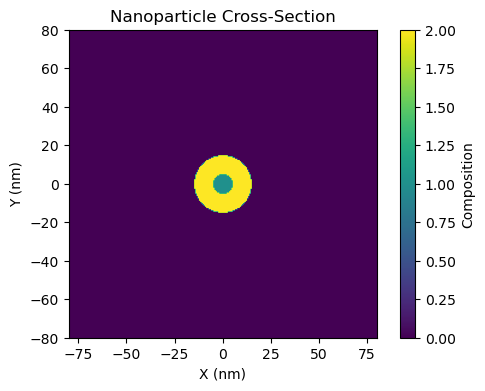

: 

In [4]:
import math
import tkinter as tk
from tkinter import ttk, messagebox
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# ---------------- Nanoparticle Builder Tab ---------------- #
class NanoparticleBuilderTab:
    def __init__(self, parent, par_editor):
        self.parent = parent
        self.par_editor = par_editor
        self.layers = []  # list of (radius, composition)

        # Frame for layer input
        input_frame = ttk.LabelFrame(parent, text="Add/Remove Layers", padding=10)
        input_frame.pack(fill="x", padx=10, pady=5)

        ttk.Label(input_frame, text="Shell Radius (nm):").grid(row=0, column=0, padx=5, sticky="w")
        ttk.Label(input_frame, text="Composition:").grid(row=0, column=1, padx=5, sticky="w")

        self.radius_var = tk.DoubleVar(value=0)
        self.comp_var = tk.StringVar()

        self.radius_entry = ttk.Entry(input_frame, textvariable=self.radius_var, width=10)
        self.radius_entry.grid(row=1, column=0, padx=5, pady=5)
        self.comp_dropdown = ttk.Combobox(input_frame, textvariable=self.comp_var, width=15,
                                          values=[
                                              "Ag_evap", "Pena26Au74Ag", "Pena100Ag",
                                              "Pena34Au66Ag", "Au_evap",
                                              "Pena15Au85Ag", "Pena52Au48Ag"
                                          ])
        self.comp_dropdown.grid(row=1, column=1, padx=5, pady=5)

        ttk.Button(input_frame, text="+ Add Layer", command=self.add_layer).grid(row=1, column=2, padx=5)
        ttk.Button(input_frame, text="- Remove Last Layer", command=self.remove_layer).grid(row=1, column=3, padx=5)

        # Listbox to show layers
        self.layer_list = tk.Listbox(parent, height=6)
        self.layer_list.pack(fill="x", padx=10, pady=5)

        # Plot area
        plot_frame = ttk.LabelFrame(parent, text="2D Cross-Section", padding=5)
        plot_frame.pack(fill="both", expand=True, padx=10, pady=5)
        self.figure, self.ax = plt.subplots(figsize=(5, 4))
        self.canvas = FigureCanvasTkAgg(self.figure, master=plot_frame)
        self.canvas.get_tk_widget().pack(fill="both", expand=True)

        # Buttons at bottom
        btn_frame = ttk.Frame(parent)
        btn_frame.pack(pady=5)
        ttk.Button(btn_frame, text="Plot Structure", command=self.plot_structure).pack(side="left", padx=5)
        ttk.Button(btn_frame, text="Save Files", command=self.save_files).pack(side="left", padx=5)

    def add_layer(self):
        try:
            radius = self.radius_var.get()
        except tk.TclError:
            messagebox.showerror("Input Error", "Invalid radius input.")
            return
        comp = self.comp_var.get().strip()
        if radius <= 0 or not comp:
            messagebox.showerror("Input Error", "Radius must be positive and composition selected.")
            return
        if self.layers and radius <= self.layers[-1][0]:
            messagebox.showerror("Input Error", "New layer radius must exceed the previous layer.")
            return
        self.layers.append((radius, comp))
        self.layer_list.insert(tk.END, f"Radius: {radius} nm, Comp: {comp}")
        self.radius_var.set(0)
        self.comp_var.set("")

    def remove_layer(self):
        if self.layers:
            self.layers.pop()
            self.layer_list.delete(tk.END)

    def plot_structure(self):
        if not self.layers:
            messagebox.showerror("Plot Error", "No layers defined.")
            return
        self.figure.clf()
        self.ax = self.figure.add_subplot(111)
        # Generate a 2D slice through the center
        N = 256
        L = 0.160  # microns
        x = np.linspace(-L / 2, L / 2, N)
        y = np.linspace(-L / 2, L / 2, N)
        X, Y = np.meshgrid(x, y)
        r = np.sqrt(X**2 + Y**2) * 1e3  # nm
        comp_grid = np.zeros_like(r, dtype=int)
        for i, (layer_r, _) in enumerate(self.layers, start=1):
            comp_grid[(r <= layer_r) & (comp_grid == 0)] = i
        cax = self.ax.imshow(comp_grid, cmap="viridis", origin="lower",
                              extent=[-L/2*1e3, L/2*1e3, -L/2*1e3, L/2*1e3])
        self.ax.set_title("Nanoparticle Cross-Section")
        self.ax.set_xlabel("X (nm)")
        self.ax.set_ylabel("Y (nm)")
        self.figure.colorbar(cax, ax=self.ax, label="Composition")
        self.canvas.draw()

    def save_files(self):
        if not self.layers:
            messagebox.showerror("Save Error", "No layers to save.")
            return

        # Save shape.dat
        shape_lines = []
        dx = dy = dz = 0.002  # microns
        L = 0.160
        Nx = math.ceil(L / dx) + 1
        Ny = math.ceil(L / dy) + 1
        Nz = math.ceil(L / dz) + 1

        shape_lines.append(">TARGSPHER  spherical target with explicit spacing")
        shape_lines.append(f"{Nx * Ny * Nz} = NAT")
        shape_lines.append("1.000000  0.000000  0.000000 = A_1 vector")
        shape_lines.append("0.000000  1.000000  0.000000 = A_2 vector")
        shape_lines.append("1.000000  1.000000  1.000000 = (d_x,d_y,d_z)/d")
        shape_lines.append(f"-{Nx//2}.5 -{Ny//2}.5 -{Nz//2}.5 = lattice offset for dipole 1,1,1")
        shape_lines.append("    JA   IX   IY   IZ ICOMP(x,y,z)")
        JA = 1
        sorted_layers = sorted(self.layers, key=lambda x: x[0])
        for ix in range(Nx):
            for iy in range(Ny):
                for iz in range(Nz):
                    x = (ix - (Nx - 1) / 2) * dx
                    y = (iy - (Ny - 1) / 2) * dy
                    z = (iz - (Nz - 1) / 2) * dz
                    r_val = np.sqrt(x**2 + y**2 + z**2) * 1e3
                    comp = 0
                    for i, (layer_r, _) in enumerate(sorted_layers, start=1):
                        if r_val <= layer_r:
                            comp = i
                            break
                    if comp:
                        shape_lines.append(f"{JA:6d} {ix+1:3d} {iy+1:3d} {iz+1:3d} {comp:1d} {comp:1d} {comp:1d}")
                        JA += 1
        shape_lines[1] = f"{JA - 1} = NAT"
        with open("shape.dat", "w") as f:
            f.write("\n".join(shape_lines))

        # Save ddscat.par using values from ParameterEditorTab
        num_layers = len(sorted_layers)
        layer_comps = [comp for (_, comp) in sorted_layers]
        par_lines = self.par_editor.get_par_content(num_layers, layer_comps)
        with open("ddscat.par", "w") as f:
            f.write("\n".join(par_lines))

        messagebox.showinfo("Save Complete", "Files saved as shape.dat and ddscat.par.")

# ---------------- Parameter Editor Tab ---------------- #
class ParameterEditorTab:
    def __init__(self, parent):
        self.parent = parent
        frame = ttk.Frame(parent, padding=10)
        frame.pack(fill="both", expand=True)

        # Preliminaries options
        prelim = ttk.LabelFrame(frame, text="Preliminaries", padding=10)
        prelim.grid(row=0, column=0, sticky="ew", padx=5, pady=5)
        self.torque = tk.StringVar(value="NOTORQ")
        self.sol_method = tk.StringVar(value="PBCGS2")
        self.fft_method = tk.StringVar(value="GPFAFT")
        self.dda_method = tk.StringVar(value="FLTRCD")
        self.binary_output = tk.StringVar(value="NOTBIN")
        ttk.Label(prelim, text="Torque:").grid(row=0, column=0, sticky="w")
        ttk.Combobox(prelim, textvariable=self.torque, values=["DOTORQ", "NOTORQ"], width=10).grid(row=0, column=1, padx=5)
        ttk.Label(prelim, text="Solution:").grid(row=1, column=0, sticky="w")
        ttk.Combobox(prelim, textvariable=self.sol_method, values=["PBCGS2", "PBCGST", "GPBICG", "QMRCCG", "PETRKP"], width=10).grid(row=1, column=1, padx=5)
        ttk.Label(prelim, text="FFT:").grid(row=0, column=2, sticky="w")
        ttk.Combobox(prelim, textvariable=self.fft_method, values=["GPFAFT", "FFTMKL"], width=10).grid(row=0, column=3, padx=5)
        ttk.Label(prelim, text="DDA:").grid(row=1, column=2, sticky="w")
        ttk.Combobox(prelim, textvariable=self.dda_method, values=["GKDLDR", "LATTDR", "FLTRCD"], width=10).grid(row=1, column=3, padx=5)
        ttk.Label(prelim, text="Binary:").grid(row=0, column=4, sticky="w")
        ttk.Combobox(prelim, textvariable=self.binary_output, values=["NOTBIN", "ORIBIN", "ALLBIN"], width=10).grid(row=0, column=5, padx=5)

        # Memory allocation
        mem = ttk.LabelFrame(frame, text="Memory Allocation", padding=10)
        mem.grid(row=1, column=0, sticky="ew", padx=5, pady=5)
        ttk.Label(mem, text="dim_x:").grid(row=0, column=0, sticky="w")
        self.mem_x = tk.IntVar(value=100)
        ttk.Entry(mem, textvariable=self.mem_x, width=5).grid(row=0, column=1, padx=5)
        ttk.Label(mem, text="dim_y:").grid(row=0, column=2, sticky="w")
        self.mem_y = tk.IntVar(value=100)
        ttk.Entry(mem, textvariable=self.mem_y, width=5).grid(row=0, column=3, padx=5)
        ttk.Label(mem, text="dim_z:").grid(row=0, column=4, sticky="w")
        self.mem_z = tk.IntVar(value=100)
        ttk.Entry(mem, textvariable=self.mem_z, width=5).grid(row=0, column=5, padx=5)

        # Wavelength
        wave = ttk.LabelFrame(frame, text="Wavelength (micron)", padding=10)
        wave.grid(row=2, column=0, sticky="ew", padx=5, pady=5)
        ttk.Label(wave, text="Start:").grid(row=0, column=0, sticky="w")
        self.wave_start = tk.DoubleVar(value=0.300)
        ttk.Entry(wave, textvariable=self.wave_start, width=8).grid(row=0, column=1, padx=5)
        ttk.Label(wave, text="End:").grid(row=0, column=2, sticky="w")
        self.wave_end = tk.DoubleVar(value=0.600)
        ttk.Entry(wave, textvariable=self.wave_end, width=8).grid(row=0, column=3, padx=5)
        ttk.Label(wave, text="Count:").grid(row=0, column=4, sticky="w")
        self.wave_count = tk.IntVar(value=150)
        ttk.Entry(wave, textvariable=self.wave_count, width=5).grid(row=0, column=5, padx=5)
        ttk.Label(wave, text="Method:").grid(row=0, column=6, sticky="w")
        self.wave_method = tk.StringVar(value="INV")
        ttk.Combobox(wave, textvariable=self.wave_method, values=["LIN", "INV", "LOG"], width=6).grid(row=0, column=7, padx=5)

        # Ambient and Effective Radii
        extra = ttk.LabelFrame(frame, text="Ambient & Effective Radii", padding=10)
        extra.grid(row=3, column=0, sticky="ew", padx=5, pady=5)
        ttk.Label(extra, text="Ambient n:").grid(row=0, column=0, sticky="w")
        self.ambient = tk.DoubleVar(value=1.333)
        ttk.Entry(extra, textvariable=self.ambient, width=8).grid(row=0, column=1, padx=5)
        ttk.Label(extra, text="Eff. Radius Start:").grid(row=0, column=2, sticky="w")
        self.eff_start = tk.DoubleVar(value=0.246186)
        ttk.Entry(extra, textvariable=self.eff_start, width=8).grid(row=0, column=3, padx=5)
        ttk.Label(extra, text="End:").grid(row=0, column=4, sticky="w")
        self.eff_end = tk.DoubleVar(value=0.246186)
        ttk.Entry(extra, textvariable=self.eff_end, width=8).grid(row=0, column=5, padx=5)
        ttk.Label(extra, text="Count:").grid(row=0, column=6, sticky="w")
        self.eff_count = tk.IntVar(value=1)
        ttk.Entry(extra, textvariable=self.eff_count, width=5).grid(row=0, column=7, padx=5)
        ttk.Label(extra, text="Method:").grid(row=0, column=8, sticky="w")
        self.eff_method = tk.StringVar(value="LIN")
        ttk.Combobox(extra, textvariable=self.eff_method, values=["LIN", "INV", "LOG"], width=6).grid(row=0, column=9, padx=5)

        # Nearfield option
        near_frame = ttk.Frame(frame, padding=5)
        near_frame.grid(row=4, column=0, sticky="w", padx=5, pady=5)
        self.nearfield_var = tk.BooleanVar(value=False)
        ttk.Checkbutton(near_frame, text="Calculate Nearfield", variable=self.nearfield_var).pack(side="left")

    def get_par_content(self, num_layers, comp_list):
        lines = []
        lines.append("' ========== Parameter file for v7.3 ==================='")
        lines.append("'**** Preliminaries ****'")
        lines.append(f"'{self.torque.get()}' = CMTORQ*6")
        lines.append(f"'{self.sol_method.get()}' = CMDSOL*6")
        lines.append(f"'{self.fft_method.get()}' = CMETHD*6")
        lines.append(f"'{self.dda_method.get()}' = CALPHA*6")
        lines.append(f"'{self.binary_output.get()}' = CBINFLAG")
        lines.append("'**** Initial Memory Allocation ****'")
        lines.append(f"{self.mem_x.get()} {self.mem_y.get()} {self.mem_z.get()} = dimensions for target generation")
        lines.append("'**** Target Geometry and Composition ****'")
        lines.append("'FROM_FILE' = CSHAPE*9 shape directive")
        lines.append("no SHPAR parameters needed")
        lines.append(f"{num_layers}         = NCOMP = number of dielectric materials")
        for i, comp in enumerate(comp_list, start=1):
            lines.append(f"'../diel/{comp}' = file with refractive index {i}")
        lines.append("'**** Additional Nearfield calculation? ****'")
        nf = "1" if self.nearfield_var.get() else "0"
        lines.append(f"{nf} = NRFLD (=0 to skip nearfield calc., =1 to calculate nearfield E)")
        lines.append("0.0 0.0 0.0 0.0 0.0 0.0 (fractional extent of calc. volume)")
        lines.append("'**** Error Tolerance ****'")
        lines.append("1.00e-7 = TOL")
        lines.append("'**** Maximum number of iterations ****'")
        lines.append("10000     = MXITER")
        lines.append("'**** Integration cutoff parameter for PBC calculations ****'")
        lines.append("1.00e-2 = GAMMA")
        lines.append("'**** Angular resolution ****'")
        lines.append("0.5\t= ETASCA")
        lines.append("'**** Vacuum wavelengths (micron) ****'")
        lines.append(f"{self.wave_start.get()} {self.wave_end.get()} {self.wave_count.get()} '{self.wave_method.get()}' = wavelengths")
        lines.append("'**** Refractive index of ambient medium ****'")
        lines.append(f"{self.ambient.get()} = NAMBIENT")
        lines.append("'**** Effective Radii (micron) ****'")
        lines.append(f"{self.eff_start.get()} {self.eff_end.get()} {self.eff_count.get()} '{self.eff_method.get()}' = eff. radii")
        lines.append("'**** Define Incident Polarizations ****'")
        lines.append("(0,0) (1.,0.) (0.,0.) = Polarization state e01")
        lines.append("2 = IORTH")
        lines.append("'**** Specify output files ****'")
        lines.append("1 = IWRKSC")
        lines.append("'**** Specify Target Rotations ****'")
        lines.append("0.    0.   1  = BETAMI, BETAMX, NBETA")
        lines.append("0.    0.   1  = THETMI, THETMX, NTHETA")
        lines.append("0.    0.   1  = PHIMIN, PHIMAX, NPHI")
        lines.append("'**** Specify first IWAV, IRAD, IORI ****'")
        lines.append("0   0   0")
        lines.append("'**** Select Elements of S_ij Matrix to Print ****'")
        lines.append("6\t= NSMELTS")
        lines.append("11 12 21 22 31 41\t= indices")
        lines.append("'**** Specify Scattered Directions ****'")
        lines.append("'LFRAME' = CMDFRM")
        lines.append("1 = NPLANES")
        lines.append("0.  0. 180. 5 = plane A")
        lines.append("90. 0. 180. 5 = plane B")
        return lines

# ---------------- Main Application ---------------- #
if __name__ == "__main__":
    root = tk.Tk()
    root.title("Core-Shell Nanoparticle Builder & Parameter Editor")
    notebook = ttk.Notebook(root)
    notebook.pack(fill="both", expand=True)

    builder_frame = ttk.Frame(notebook)
    par_frame = ttk.Frame(notebook)
    notebook.add(builder_frame, text="Nanoparticle Builder")
    notebook.add(par_frame, text="Parameter Editor")

    par_editor = ParameterEditorTab(par_frame)
    builder_tab = NanoparticleBuilderTab(builder_frame, par_editor)

    root.mainloop()


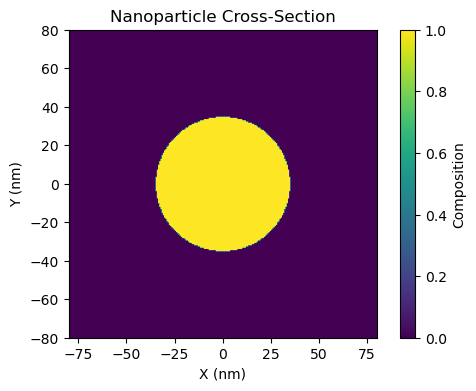

In [1]:
import math
import tkinter as tk
from tkinter import ttk, messagebox
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# ---------------- Nanoparticle Builder Tab ---------------- #
class NanoparticleBuilderTab:
    def __init__(self, parent, par_editor):
        self.parent = parent
        self.par_editor = par_editor
        self.layers = []  # list of (radius, composition)

        # Frame for layer input
        input_frame = ttk.LabelFrame(parent, text="Add/Remove Layers", padding=10)
        input_frame.pack(fill="x", padx=10, pady=5)

        ttk.Label(input_frame, text="Shell Radius (nm):").grid(row=0, column=0, padx=5, sticky="w")
        ttk.Label(input_frame, text="Composition:").grid(row=0, column=1, padx=5, sticky="w")

        self.radius_var = tk.DoubleVar(value=0)
        self.comp_var = tk.StringVar()

        self.radius_entry = ttk.Entry(input_frame, textvariable=self.radius_var, width=10)
        self.radius_entry.grid(row=1, column=0, padx=5, pady=5)
        self.comp_dropdown = ttk.Combobox(input_frame, textvariable=self.comp_var, width=15,
                                          values=[
                                              "Ag_evap", "Pena26Au74Ag", "Pena100Ag",
                                              "Pena34Au66Ag", "Au_evap",
                                              "Pena15Au85Ag", "Pena52Au48Ag"
                                          ])
        self.comp_dropdown.grid(row=1, column=1, padx=5, pady=5)

        ttk.Button(input_frame, text="+ Add Layer", command=self.add_layer).grid(row=1, column=2, padx=5)
        ttk.Button(input_frame, text="- Remove Last Layer", command=self.remove_layer).grid(row=1, column=3, padx=5)

        # Listbox to show layers
        self.layer_list = tk.Listbox(parent, height=6)
        self.layer_list.pack(fill="x", padx=10, pady=5)

        # Discretization Settings Frame
        disc_frame = ttk.LabelFrame(parent, text="Discretization Settings (microns)", padding=10)
        disc_frame.pack(fill="x", padx=10, pady=5)

        ttk.Label(disc_frame, text="L (overall size):").grid(row=0, column=0, sticky="w", padx=5)
        self.L_var = tk.DoubleVar(value=0.160)
        ttk.Entry(disc_frame, textvariable=self.L_var, width=8).grid(row=0, column=1, padx=5)

        ttk.Label(disc_frame, text="dx:").grid(row=0, column=2, sticky="w", padx=5)
        self.dx_var = tk.DoubleVar(value=0.002)
        ttk.Entry(disc_frame, textvariable=self.dx_var, width=8).grid(row=0, column=3, padx=5)

        ttk.Label(disc_frame, text="dy:").grid(row=0, column=4, sticky="w", padx=5)
        self.dy_var = tk.DoubleVar(value=0.002)
        ttk.Entry(disc_frame, textvariable=self.dy_var, width=8).grid(row=0, column=5, padx=5)

        ttk.Label(disc_frame, text="dz:").grid(row=0, column=6, sticky="w", padx=5)
        self.dz_var = tk.DoubleVar(value=0.002)
        ttk.Entry(disc_frame, textvariable=self.dz_var, width=8).grid(row=0, column=7, padx=5)

        self.dipoles_label = ttk.Label(disc_frame, text="Expected Dipoles: calculating...")
        self.dipoles_label.grid(row=1, column=0, columnspan=8, pady=5)

        # Trace changes to update dipole count
        for var in (self.L_var, self.dx_var, self.dy_var, self.dz_var):
            var.trace_add("write", self.update_dipole_count)
        self.update_dipole_count()

        # Plot area
        plot_frame = ttk.LabelFrame(parent, text="2D Cross-Section", padding=5)
        plot_frame.pack(fill="both", expand=True, padx=10, pady=5)
        self.figure, self.ax = plt.subplots(figsize=(5, 4))
        self.canvas = FigureCanvasTkAgg(self.figure, master=plot_frame)
        self.canvas.get_tk_widget().pack(fill="both", expand=True)

        # Buttons at bottom
        btn_frame = ttk.Frame(parent)
        btn_frame.pack(pady=5)
        ttk.Button(btn_frame, text="Plot Structure", command=self.plot_structure).pack(side="left", padx=5)
        ttk.Button(btn_frame, text="Save Files", command=self.save_files).pack(side="left", padx=5)

    def update_dipole_count(self, *args):
        try:
            L = self.L_var.get()
            dx = self.dx_var.get()
            dy = self.dy_var.get()
            dz = self.dz_var.get()
            if dx <= 0 or dy <= 0 or dz <= 0 or L <= 0:
                raise ValueError
            Nx = math.ceil(L / dx) + 1
            Ny = math.ceil(L / dy) + 1
            Nz = math.ceil(L / dz) + 1
            count = Nx * Ny * Nz
            self.dipoles_label.config(text=f"Expected Dipoles: {count} (Nx={Nx}, Ny={Ny}, Nz={Nz})")
        except Exception:
            self.dipoles_label.config(text="Expected Dipoles: error in parameters")

    def add_layer(self):
        try:
            radius = self.radius_var.get()
        except tk.TclError:
            messagebox.showerror("Input Error", "Invalid radius input.")
            return
        comp = self.comp_var.get().strip()
        if radius <= 0 or not comp:
            messagebox.showerror("Input Error", "Radius must be positive and composition selected.")
            return
        if self.layers and radius <= self.layers[-1][0]:
            messagebox.showerror("Input Error", "New layer radius must exceed the previous layer.")
            return
        self.layers.append((radius, comp))
        self.layer_list.insert(tk.END, f"Radius: {radius} nm, Comp: {comp}")
        self.radius_var.set(0)
        self.comp_var.set("")

    def remove_layer(self):
        if self.layers:
            self.layers.pop()
            self.layer_list.delete(tk.END)

    def plot_structure(self):
        if not self.layers:
            messagebox.showerror("Plot Error", "No layers defined.")
            return
        self.figure.clf()
        self.ax = self.figure.add_subplot(111)
        # Generate a 2D slice through the center
        N = 256
        L = self.L_var.get()  # microns
        x = np.linspace(-L / 2, L / 2, N)
        y = np.linspace(-L / 2, L / 2, N)
        X, Y = np.meshgrid(x, y)
        r = np.sqrt(X**2 + Y**2) * 1e3  # nm
        comp_grid = np.zeros_like(r, dtype=int)
        for i, (layer_r, _) in enumerate(self.layers, start=1):
            comp_grid[(r <= layer_r) & (comp_grid == 0)] = i
        cax = self.ax.imshow(comp_grid, cmap="viridis", origin="lower",
                              extent=[-L/2*1e3, L/2*1e3, -L/2*1e3, L/2*1e3])
        self.ax.set_title("Nanoparticle Cross-Section")
        self.ax.set_xlabel("X (nm)")
        self.ax.set_ylabel("Y (nm)")
        self.figure.colorbar(cax, ax=self.ax, label="Composition")
        self.canvas.draw()

    def save_files(self):
        if not self.layers:
            messagebox.showerror("Save Error", "No layers to save.")
            return

        # Save shape.dat using discretization settings
        shape_lines = []
        dx = self.dx_var.get()
        dy = self.dy_var.get()
        dz = self.dz_var.get()
        L = self.L_var.get()
        Nx = math.ceil(L / dx) + 1
        Ny = math.ceil(L / dy) + 1
        Nz = math.ceil(L / dz) + 1

        shape_lines.append(">TARGSPHER  spherical target with explicit spacing")
        shape_lines.append(f"{Nx * Ny * Nz} = NAT")
        shape_lines.append("1.000000  0.000000  0.000000 = A_1 vector")
        shape_lines.append("0.000000  1.000000  0.000000 = A_2 vector")
        shape_lines.append("1.000000  1.000000  1.000000 = (d_x,d_y,d_z)/d")
        shape_lines.append(f"-{Nx//2}.5 -{Ny//2}.5 -{Nz//2}.5 = lattice offset for dipole 1,1,1")
        shape_lines.append("    JA   IX   IY   IZ ICOMP(x,y,z)")
        JA = 1
        sorted_layers = sorted(self.layers, key=lambda x: x[0])
        for ix in range(Nx):
            for iy in range(Ny):
                for iz in range(Nz):
                    x_val = (ix - (Nx - 1) / 2) * dx
                    y_val = (iy - (Ny - 1) / 2) * dy
                    z_val = (iz - (Nz - 1) / 2) * dz
                    r_val = np.sqrt(x_val**2 + y_val**2 + z_val**2) * 1e3
                    comp = 0
                    for i, (layer_r, _) in enumerate(sorted_layers, start=1):
                        if r_val <= layer_r:
                            comp = i
                            break
                    if comp:
                        shape_lines.append(f"{JA:6d} {ix+1:3d} {iy+1:3d} {iz+1:3d} {comp:1d} {comp:1d} {comp:1d}")
                        JA += 1
        shape_lines[1] = f"{JA - 1} = NAT"
        with open("shape.dat", "w") as f:
            f.write("\n".join(shape_lines))

        # Save ddscat.par using values from ParameterEditorTab
        num_layers = len(sorted_layers)
        layer_comps = [comp for (_, comp) in sorted_layers]
        par_lines = self.par_editor.get_par_content(num_layers, layer_comps)
        with open("ddscat.par", "w") as f:
            f.write("\n".join(par_lines))

        messagebox.showinfo("Save Complete", "Files saved as shape.dat and ddscat.par.")

# ---------------- Parameter Editor Tab ---------------- #
class ParameterEditorTab:
    def __init__(self, parent):
        self.parent = parent
        frame = ttk.Frame(parent, padding=10)
        frame.pack(fill="both", expand=True)

        # Preliminaries options
        prelim = ttk.LabelFrame(frame, text="Preliminaries", padding=10)
        prelim.grid(row=0, column=0, sticky="ew", padx=5, pady=5)
        self.torque = tk.StringVar(value="NOTORQ")
        self.sol_method = tk.StringVar(value="PBCGS2")
        self.fft_method = tk.StringVar(value="GPFAFT")
        self.dda_method = tk.StringVar(value="FLTRCD")
        self.binary_output = tk.StringVar(value="NOTBIN")
        ttk.Label(prelim, text="Torque:").grid(row=0, column=0, sticky="w")
        ttk.Combobox(prelim, textvariable=self.torque, values=["DOTORQ", "NOTORQ"], width=10).grid(row=0, column=1, padx=5)
        ttk.Label(prelim, text="Solution:").grid(row=1, column=0, sticky="w")
        ttk.Combobox(prelim, textvariable=self.sol_method, values=["PBCGS2", "PBCGST", "GPBICG", "QMRCCG", "PETRKP"], width=10).grid(row=1, column=1, padx=5)
        ttk.Label(prelim, text="FFT:").grid(row=0, column=2, sticky="w")
        ttk.Combobox(prelim, textvariable=self.fft_method, values=["GPFAFT", "FFTMKL"], width=10).grid(row=0, column=3, padx=5)
        ttk.Label(prelim, text="DDA:").grid(row=1, column=2, sticky="w")
        ttk.Combobox(prelim, textvariable=self.dda_method, values=["GKDLDR", "LATTDR", "FLTRCD"], width=10).grid(row=1, column=3, padx=5)
        ttk.Label(prelim, text="Binary:").grid(row=0, column=4, sticky="w")
        ttk.Combobox(prelim, textvariable=self.binary_output, values=["NOTBIN", "ORIBIN", "ALLBIN"], width=10).grid(row=0, column=5, padx=5)

        # Memory allocation
        mem = ttk.LabelFrame(frame, text="Memory Allocation", padding=10)
        mem.grid(row=1, column=0, sticky="ew", padx=5, pady=5)
        ttk.Label(mem, text="dim_x:").grid(row=0, column=0, sticky="w")
        self.mem_x = tk.IntVar(value=100)
        ttk.Entry(mem, textvariable=self.mem_x, width=5).grid(row=0, column=1, padx=5)
        ttk.Label(mem, text="dim_y:").grid(row=0, column=2, sticky="w")
        self.mem_y = tk.IntVar(value=100)
        ttk.Entry(mem, textvariable=self.mem_y, width=5).grid(row=0, column=3, padx=5)
        ttk.Label(mem, text="dim_z:").grid(row=0, column=4, sticky="w")
        self.mem_z = tk.IntVar(value=100)
        ttk.Entry(mem, textvariable=self.mem_z, width=5).grid(row=0, column=5, padx=5)

        # Wavelength
        wave = ttk.LabelFrame(frame, text="Wavelength (micron)", padding=10)
        wave.grid(row=2, column=0, sticky="ew", padx=5, pady=5)
        ttk.Label(wave, text="Start:").grid(row=0, column=0, sticky="w")
        self.wave_start = tk.DoubleVar(value=0.300)
        ttk.Entry(wave, textvariable=self.wave_start, width=8).grid(row=0, column=1, padx=5)
        ttk.Label(wave, text="End:").grid(row=0, column=2, sticky="w")
        self.wave_end = tk.DoubleVar(value=0.600)
        ttk.Entry(wave, textvariable=self.wave_end, width=8).grid(row=0, column=3, padx=5)
        ttk.Label(wave, text="Count:").grid(row=0, column=4, sticky="w")
        self.wave_count = tk.IntVar(value=150)
        ttk.Entry(wave, textvariable=self.wave_count, width=5).grid(row=0, column=5, padx=5)
        ttk.Label(wave, text="Method:").grid(row=0, column=6, sticky="w")
        self.wave_method = tk.StringVar(value="INV")
        ttk.Combobox(wave, textvariable=self.wave_method, values=["LIN", "INV", "LOG"], width=6).grid(row=0, column=7, padx=5)

        # Ambient and Effective Radii
        extra = ttk.LabelFrame(frame, text="Ambient & Effective Radii", padding=10)
        extra.grid(row=3, column=0, sticky="ew", padx=5, pady=5)
        ttk.Label(extra, text="Ambient n:").grid(row=0, column=0, sticky="w")
        self.ambient = tk.DoubleVar(value=1.333)
        ttk.Entry(extra, textvariable=self.ambient, width=8).grid(row=0, column=1, padx=5)
        ttk.Label(extra, text="Eff. Radius Start:").grid(row=0, column=2, sticky="w")
        self.eff_start = tk.DoubleVar(value=0.246186)
        ttk.Entry(extra, textvariable=self.eff_start, width=8).grid(row=0, column=3, padx=5)
        ttk.Label(extra, text="End:").grid(row=0, column=4, sticky="w")
        self.eff_end = tk.DoubleVar(value=0.246186)
        ttk.Entry(extra, textvariable=self.eff_end, width=8).grid(row=0, column=5, padx=5)
        ttk.Label(extra, text="Count:").grid(row=0, column=6, sticky="w")
        self.eff_count = tk.IntVar(value=1)
        ttk.Entry(extra, textvariable=self.eff_count, width=5).grid(row=0, column=7, padx=5)
        ttk.Label(extra, text="Method:").grid(row=0, column=8, sticky="w")
        self.eff_method = tk.StringVar(value="LIN")
        ttk.Combobox(extra, textvariable=self.eff_method, values=["LIN", "INV", "LOG"], width=6).grid(row=0, column=9, padx=5)

        # Nearfield option
        near_frame = ttk.Frame(frame, padding=5)
        near_frame.grid(row=4, column=0, sticky="w", padx=5, pady=5)
        self.nearfield_var = tk.BooleanVar(value=False)
        ttk.Checkbutton(near_frame, text="Calculate Nearfield", variable=self.nearfield_var).pack(side="left")

    def get_par_content(self, num_layers, comp_list):
        lines = []
        lines.append("' ========== Parameter file for v7.3 ==================='")
        lines.append("'**** Preliminaries ****'")
        lines.append(f"'{self.torque.get()}' = CMTORQ*6")
        lines.append(f"'{self.sol_method.get()}' = CMDSOL*6")
        lines.append(f"'{self.fft_method.get()}' = CMETHD*6")
        lines.append(f"'{self.dda_method.get()}' = CALPHA*6")
        lines.append(f"'{self.binary_output.get()}' = CBINFLAG")
        lines.append("'**** Initial Memory Allocation ****'")
        lines.append(f"{self.mem_x.get()} {self.mem_y.get()} {self.mem_z.get()} = dimensions for target generation")
        lines.append("'**** Target Geometry and Composition ****'")
        lines.append("'FROM_FILE' = CSHAPE*9 shape directive")
        lines.append("no SHPAR parameters needed")
        lines.append(f"{num_layers}         = NCOMP = number of dielectric materials")
        for i, comp in enumerate(comp_list, start=1):
            lines.append(f"'../diel/{comp}' = file with refractive index {i}")
        lines.append("'**** Additional Nearfield calculation? ****'")
        nf = "1" if self.nearfield_var.get() else "0"
        lines.append(f"{nf} = NRFLD (=0 to skip nearfield calc., =1 to calculate nearfield E)")
        lines.append("0.0 0.0 0.0 0.0 0.0 0.0 (fractional extent of calc. volume)")
        lines.append("'**** Error Tolerance ****'")
        lines.append("1.00e-7 = TOL")
        lines.append("'**** Maximum number of iterations ****'")
        lines.append("10000     = MXITER")
        lines.append("'**** Integration cutoff parameter for PBC calculations ****'")
        lines.append("1.00e-2 = GAMMA")
        lines.append("'**** Angular resolution ****'")
        lines.append("0.5\t= ETASCA")
        lines.append("'**** Vacuum wavelengths (micron) ****'")
        lines.append(f"{self.wave_start.get()} {self.wave_end.get()} {self.wave_count.get()} '{self.wave_method.get()}' = wavelengths")
        lines.append("'**** Refractive index of ambient medium ****'")
        lines.append(f"{self.ambient.get()} = NAMBIENT")
        lines.append("'**** Effective Radii (micron) ****'")
        lines.append(f"{self.eff_start.get()} {self.eff_end.get()} {self.eff_count.get()} '{self.eff_method.get()}' = eff. radii")
        lines.append("'**** Define Incident Polarizations ****'")
        lines.append("(0,0) (1.,0.) (0.,0.) = Polarization state e01")
        lines.append("2 = IORTH")
        lines.append("'**** Specify output files ****'")
        lines.append("1 = IWRKSC")
        lines.append("'**** Specify Target Rotations ****'")
        lines.append("0.    0.   1  = BETAMI, BETAMX, NBETA")
        lines.append("0.    0.   1  = THETMI, THETMX, NTHETA")
        lines.append("0.    0.   1  = PHIMIN, PHIMAX, NPHI")
        lines.append("'**** Specify first IWAV, IRAD, IORI ****'")
        lines.append("0   0   0")
        lines.append("'**** Select Elements of S_ij Matrix to Print ****'")
        lines.append("6\t= NSMELTS")
        lines.append("11 12 21 22 31 41\t= indices")
        lines.append("'**** Specify Scattered Directions ****'")
        lines.append("'LFRAME' = CMDFRM")
        lines.append("1 = NPLANES")
        lines.append("0.  0. 180. 5 = plane A")
        lines.append("90. 0. 180. 5 = plane B")
        return lines

# ---------------- Main Application ---------------- #
if __name__ == "__main__":
    root = tk.Tk()
    root.title("Core-Shell Nanoparticle Builder & Parameter Editor")
    notebook = ttk.Notebook(root)
    notebook.pack(fill="both", expand=True)

    builder_frame = ttk.Frame(notebook)
    par_frame = ttk.Frame(notebook)
    notebook.add(builder_frame, text="Nanoparticle Builder")
    notebook.add(par_frame, text="Parameter Editor")

    par_editor = ParameterEditorTab(par_frame)
    builder_tab = NanoparticleBuilderTab(builder_frame, par_editor)

    root.mainloop()
